## General Imports

In [60]:
import pandas as pd
import numpy as np
import copy
import os
from copy import deepcopy
import time
from itertools import combinations, permutations
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from copy import deepcopy
from gcastle_debug import orient_update, get_causal_matrix
from castle.algorithms import PC
from castle.algorithms.pc.pc import find_skeleton
from castle.common import Tensor
from castle.common.priori_knowledge import orient_by_priori_knowledge
from castle.common import BaseLearner, Tensor
from castle.algorithms.ges.operators import search
from castle.algorithms.ges.score.local_scores import (BICScore, BDeuScore, DecomposableScore)
import networkx as nx
from graphviz import Digraph
# Work directory
os.chdir('../data')

# Needed Functions for Causal Matrix, Causal graph and Statistical Disparity

In [61]:
# PC algorithm 
class PC_algorithm(PC):

    def __init__(self,ci_test='fisherz'):
        super(PC_algorithm, self).__init__(
            
            ci_test=ci_test
        )

    def learn(self, data, columns=None, **kwargs):
        data = Tensor(data, columns=columns)

        skeleton, sep_set = find_skeleton(data,
                                          alpha=self.alpha,
                                          ci_test=self.ci_test,
                                          variant=self.variant,
                                          priori_knowledge=self.priori_knowledge,
                                          **kwargs)

        self._causal_matrix = Tensor(
            orient_update(skeleton, sep_set, self.priori_knowledge).astype(int),
            index=data.columns,
            columns=data.columns
        )

class GES(BaseLearner):

    def __init__(self, criterion='bic', method='scatter', k=0.001, N=10):
        super(GES, self).__init__()
        if isinstance(criterion, str):
            if criterion not in ['bic', 'bdeu']:
                raise ValueError(f"if criterion is str, it must be one of "
                                 f"['bic', 'bdeu'], but got {criterion}.")
        else:
            if not isinstance(criterion, DecomposableScore):
                raise TypeError(f"The criterion is not instance of "
                                f"DecomposableScore.")
        self.criterion = criterion
        self.method = method
        self.k = k
        self.N = N

    def learn(self, data, columns=None, **kwargs):

        d = data.shape[1]
        e = np.zeros((d, d), dtype=int)

        if self.criterion == 'bic':
            self.criterion = BICScore(data=data,
                                      method=self.method)
        elif self.criterion == 'bdeu':
            self.criterion = BDeuScore(data=data, k=self.k, N=self.N)

        c = search.fes(C=e, criterion=self.criterion)
        c = search.bes(C=c, criterion=self.criterion)

        self._causal_matrix = Tensor(c, index=columns, columns=columns)
    

# function for adjacency matrices generation when the outcome is not binarized (needed to check the impact of binarization on causal discovery)
def adj_matrices_generation_baseline(df):
#     # reading data distribution
#     print('++++++++++++++++++++++++++++++++++++++++++++')
#     print(df.Y.describe())

#     A0_Y0 = len(df[(df['A'] == 0) & (df['Y'] == 0)])
#     A0_Y1 = len(df[(df['A'] == 0) & (df['Y'] == 1)])
#     A1_Y0 = len(df[(df['A'] == 1) & (df['Y'] == 0)])
#     A1_Y1 = len(df[(df['A'] == 1) & (df['Y'] == 1)])
    
    accumulated_AM = []    
    for seed in range(nb_seeds):  
        #print('Seed_:  ' + ''.join(str(seed)))
        # applying PC
        method = PC_algorithm()
        method.learn(df)
        causal_matrix = get_causal_matrix(method.causal_matrix)
        #print(f' estimated causal graph:  {causal_matrix} \n') 
        accumulated_AM.append(causal_matrix)
    return accumulated_AM


#************************** End of the baseline *************************#

#************************** For the after binarization ******************#

# function for adjacency matrices generation when binarizing the outcome
def adj_matrices_generation(df,Y_thresh,nb_seeds):     
    listCM_th = []
    for th in Y_thresh:  
        print('Threshold:  ' + ''.join(str(th)))
        synthCopy = deepcopy(df)
        df[target] = np.where(df[target] > th, 1, 0)   
        # reading data distribution
        print('++++++++++++++++++++++++++++++++++++++++++++')
        print(df[target].value_counts())
        A0_Y0 = len(df[(df[target] == 0) & (df[target] == 0)])
        A0_Y1 = len(df[(df[target] == 0) & (df[target] == 1)])
        A1_Y0 = len(df[(df[target] == 1) & (df[target] == 0)])
        A1_Y1 = len(df[(df[target] == 1) & (df[target] == 1)])
        A0, A1 = len(df[(df[target] == 0)]), len(df[(df[protected_att] == 1)])
        #print(f'A0_Y0: {A0_Y0}\n A0_Y1: {A0_Y1}\n A1_Y0: {A1_Y0}\n A1_Y1: {A1_Y1}')
        
        print(f'sd = {(A1_Y1/A1)-(A0_Y1/A0)} \n')
        
        th_adj_matrix = []
        for seed in range(nb_seeds):
            #print('Seed_:  ' + ''.join(str(seed)))
            # applying PC
            method = PC_algorithm()
            method.learn(df)
            causal_matrix = get_causal_matrix(method.causal_matrix)
            #print(f' estimated causal graph:  {causal_matrix} \n')        
            th_adj_matrix.append(causal_matrix)
        print(f'before -- {th_adj_matrix}\n')
        th_adj_matrix = np.sum(th_adj_matrix,axis=0)/len(th_adj_matrix)
        print(f'after --{th_adj_matrix}')
        df[target] = synthCopy[target]        
        listCM_th.append(th_adj_matrix)
    return listCM_th

# Generate and save causal graph from a causal matrix
def generate_and_save_causal_graph(causal_matrix, variable_names, filename, output_path="causal_graphs"):
    """
    Generates and saves a causal graph based on the given causal matrix.
    
    Parameters:
        causal_matrix (numpy.ndarray): The adjacency matrix representing causal relationships.
        variable_names (list): List of variable names corresponding to the nodes in the causal matrix.
        filename (str): The base filename for saving the graph images.
        output_path (str): Directory path where the graph images will be saved.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # create a directed graph from the causal matrix
    graph = nx.DiGraph()
    for i in range(causal_matrix.shape[0]):
        for j in range(causal_matrix.shape[1]):
            if causal_matrix[i, j] == 1:
                source, target = variable_names[i], variable_names[j]
                graph.add_edge(source, target)

    # Define the full path for saving the graph images
    graphviz_filename = os.path.join(output_path, f"{filename}.gv")

    # Save the graph as a PNG file
    dot = Digraph(format='png')
    for edge in graph.edges:
        dot.edge(edge[0], edge[1])
    dot.render(filename=graphviz_filename, cleanup=True)

    print(f"Causal graph saved as '{graphviz_filename}.png'.")

def calculate_statistical_disparity(df, outcome_col=None, protected_col=None):
    """
    Calculate statistical disparity: P[Y=1|A=1] - P[Y=1|A=0]
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the outcome and protected attribute columns
    outcome_col : str
        Name of the column containing the outcome variable
    protected_col : str
        Name of the column containing the protected attribute
        
    Returns:
    --------
    float
        Statistical disparity value
    dict
        Dictionary containing P[Y=1|A=1] and P[Y=1|A=0]
    """
    if outcome_col is None:
        outcome_col = target
    if protected_col is None:
        protected_col = protected_att
        
    # Calculate conditional probabilities
    P_y1_A1 = len(df[(df[protected_col] == 1) & (df[outcome_col] == 1)]) / len(df[df[protected_col] == 1])
    P_y1_A0 = len(df[(df[protected_col] == 0) & (df[outcome_col] == 1)]) / len(df[df[protected_col] == 0])
    
    # Calculate statistical disparity
    disparity = P_y1_A1 - P_y1_A0
    
    return disparity, {'P_y1_A1': P_y1_A1, 'P_y1_A0': P_y1_A0}

def calculate_probabilities(df, outcome_col=None, protected_col=None):
    """
    Calculate joint and conditional probabilities
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the outcome and protected attribute columns
    outcome_col : str
        Name of the column containing the outcome variable
    protected_col : str
        Name of the column containing the protected attribute
        
    Returns:
    --------
    dict
        Dictionary containing various probability calculations
    """
    if outcome_col is None:
        outcome_col = target
    if protected_col is None:
        protected_col = protected_att
        
    total_samples = len(df)
    
    # Joint probabilities P(A,Y)
    P_A1_Y1 = len(df[(df[protected_col] == 1) & (df[outcome_col] == 1)]) / total_samples
    P_A1_Y0 = len(df[(df[protected_col] == 1) & (df[outcome_col] == 0)]) / total_samples
    P_A0_Y1 = len(df[(df[protected_col] == 0) & (df[outcome_col] == 1)]) / total_samples
    P_A0_Y0 = len(df[(df[protected_col] == 0) & (df[outcome_col] == 0)]) / total_samples
    
    # Marginal probabilities P(A) and P(Y)
    P_A1 = len(df[df[protected_col] == 1]) / total_samples
    P_A0 = len(df[df[protected_col] == 0]) / total_samples
    P_Y1 = len(df[df[outcome_col] == 1]) / total_samples
    P_Y0 = len(df[df[outcome_col] == 0]) / total_samples
    
    # Conditional probabilities P(Y|A)
    P_Y1_A1 = P_A1_Y1 / P_A1 if P_A1 != 0 else 0
    P_Y0_A1 = P_A1_Y0 / P_A1 if P_A1 != 0 else 0
    P_Y1_A0 = P_A0_Y1 / P_A0 if P_A0 != 0 else 0
    P_Y0_A0 = P_A0_Y0 / P_A0 if P_A0 != 0 else 0
    
    return {
        'joint_probabilities': {
            'P(A=1,Y=1)': P_A1_Y1,
            'P(A=0,Y=1)': P_A0_Y1
        },
        'conditional_probabilities_Y_given_A': {
            'P(Y=1|A=1)': P_Y1_A1,
            'P(Y=1|A=0)': P_Y1_A0
        }
    }

def analyze_thresholds(df, thresholds, outcome_col=None, protected_col=None):
    """
    Analyze statistical disparity and probabilities for different thresholds
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original DataFrame
    thresholds : list
        List of threshold values to analyze
    outcome_col : str
        Name of the column containing the outcome variable
    protected_col : str
        Name of the column containing the protected attribute
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing analysis results for each threshold
    """
    if outcome_col is None:
        outcome_col = target
    if protected_col is None:
        protected_col = protected_att
        
    results = []
    
    for threshold in thresholds:
        # Create copy of DataFrame and binarize outcome
        df_copy = df.copy()
        df_copy[outcome_col] = np.where(df_copy[outcome_col] > threshold, 1, 0)
        
        # Calculate statistical disparity
        disparity, cond_probs = calculate_statistical_disparity(df_copy, outcome_col, protected_col)
        
        # Calculate probabilities
        probs = calculate_probabilities(df_copy, outcome_col, protected_col)
        
        # Store results
        result = {
            'threshold': threshold,
            'statistical_disparity': disparity,
            'P(A=1,Y=1)': probs['joint_probabilities']['P(A=1,Y=1)'],
            'P(A=0,Y=1)': probs['joint_probabilities']['P(A=0,Y=1)'],
            'P(Y=1|A=1)': probs['conditional_probabilities_Y_given_A']['P(Y=1|A=1)'],
            'P(Y=1|A=0)': probs['conditional_probabilities_Y_given_A']['P(Y=1|A=0)']
        }
        results.append(result)
    
    return pd.DataFrame(results)

def plot_threshold_analysis(df, Y_thresholds):
    """
    Create visualization of statistical disparity across thresholds
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Original DataFrame
    Y_thresholds : list
        List of thresholds to analyze
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing analysis results for each threshold
    """
    results = []
    
    for threshold in Y_thresholds:
        print(f"\n=== Analysis for Threshold {threshold:.2f} ===")
        
        # Create copy of DataFrame and binarize outcome
        df_copy = df.copy()
        df_copy[target] = np.where(df_copy[target] > threshold, 1, 0)
        
        # Calculate statistical disparity
        disparity, cond_probs = calculate_statistical_disparity(df_copy)
        
        # Calculate probabilities
        probs = calculate_probabilities(df_copy)
        
        # Print results for this threshold
        print("\n1. Statistical Disparity:")
        print(f"   {disparity:.3f}")
        
        print("\n2. Joint Probabilities:")
        print(f"   P(A=1,Y=1): {probs['joint_probabilities']['P(A=1,Y=1)']:.3f}")
        print(f"   P(A=0,Y=1): {probs['joint_probabilities']['P(A=0,Y=1)']:.3f}")
            
        print("\n3. Conditional Probabilities P(Y|A):")
        print(f"   P(Y=1|A=1): {probs['conditional_probabilities_Y_given_A']['P(Y=1|A=1)']:.3f}")
        print(f"   P(Y=1|A=0): {probs['conditional_probabilities_Y_given_A']['P(Y=1|A=0)']:.3f}")
        
        # Store results
        result = {
            'threshold': threshold,
            'statistical_disparity': disparity,
            'P(A=1,Y=1)': probs['joint_probabilities']['P(A=1,Y=1)'],
            'P(A=0,Y=1)': probs['joint_probabilities']['P(A=0,Y=1)'],
            'P(Y=1|A=1)': probs['conditional_probabilities_Y_given_A']['P(Y=1|A=1)'],
            'P(Y=1|A=0)': probs['conditional_probabilities_Y_given_A']['P(Y=1|A=0)']
        }
        results.append(result)
    
    # Convert results to DataFrame
    analysis_results = pd.DataFrame(results)
    
    # Create single figure for Statistical Disparity
    plt.figure(figsize=(10, 6))
    plt.plot(analysis_results['threshold'], analysis_results['statistical_disparity'], 
             marker='o', linestyle='-', color='red', linewidth=2)
    plt.title('Statistical Disparity vs Threshold', fontsize=14, pad=20)
    plt.xlabel('Y Threshold', fontsize=12)
    plt.ylabel('Statistical Disparity', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add minor gridlines for better readability
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.minorticks_on()
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot as PNG
    plt.savefig(os.path.join(results_path, 'statistical_disparity.png'), 
                dpi=300, bbox_inches='tight', format='png')
    plt.show()
    
    # Create summary table
    print("\nSummary Table of Results:")
    summary_cols = ['threshold', 'statistical_disparity', 
                   'P(A=1,Y=1)', 'P(A=0,Y=1)',
                   'P(Y=1|A=1)', 'P(Y=1|A=0)']
    print(analysis_results[summary_cols].round(3))
    
    return analysis_results

# Synthetic Data

## Static parameters

In [62]:
nb_seeds = 10
# Target attribute
target = 'Y'
# Protected attribute 
protected_att = 'A'
# Folder where datasets are saved as csv files
datasets_path = os.path.join(os.getcwd(), 'Datasets/Synthetic/')
# Folder where plots are saved as pdf files
results_path = os.path.join(os.getcwd(), 'Plots/Synthetic/')

dataset_filename = 'synthetic.csv'

percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
Y_thresholds = [f"th_{int(p*100)}%" for p in percentiles]

# Reading preprocessed dataset
df = pd.read_csv(os.path.join(datasets_path, dataset_filename))

# variable names
variable_names = ['C', 'A', 'M', 'Y']

## Running experiments for the baseline causal model 

In [63]:
# results of PC estimation before binarization (baseline)
result_baseline = adj_matrices_generation_baseline(df)
causal_matrix = np.mean(result_baseline, axis=0)

# generate and save causal graph
generate_and_save_causal_graph(causal_matrix, variable_names, "causal_graph_synthetic_baseline", "causal_graphs/Synthetic")


Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_baseline.gv.png'.


## Running experiments for the causal model after binarizing the outcome

In [64]:
# generating the adj matrices for all thresholds
Y_thresh = [df[target].quantile(p) for p in percentiles]
th_adj_matrix = adj_matrices_generation(df,Y_thresh,nb_seeds)

Threshold:  0.2625602566350938
++++++++++++++++++++++++++++++++++++++++++++
1    900
0    100
Name: Y, dtype: int64
sd = 1.9027484143763214 

before -- [array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0,

In [65]:
# generate and save causal graphs for each threshold
for i, causal_matrix in enumerate(th_adj_matrix):
    threshold = Y_thresholds[i]
    filename = f"causal_graph_synthetic_{threshold}"
    generate_and_save_causal_graph(causal_matrix, variable_names, filename, "causal_graphs/Synthetic")

Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_10%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_20%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_30%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_40%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_50%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_60%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_70%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_80%.gv.png'.
Causal graph saved as 'causal_graphs/Synthetic/causal_graph_synthetic_th_90%.gv.png'.


## Check Statistical Disparity

In [66]:
# Baseline Disparity Ratio
# SD = E[Y|A=1] / E[Y|A=0]

E_Y_given_A1 = df[df[protected_att] == 1][target].mean()  # E[Y|A=1]
E_Y_given_A0 = df[df[protected_att] == 0][target].mean()  # E[Y|A=0]
SD = E_Y_given_A1 / E_Y_given_A0  # SD = E[Y|A=1] / E[Y|A=0]

print("\n=== Baseline Disparity Ratio ===")
print(f"E[Y|A=1]: {E_Y_given_A1:.3f}")
print(f"E[Y|A=0]: {E_Y_given_A0:.3f}")
print(f"Disparity Ratio: {SD:.3f}")


=== Baseline Disparity Ratio ===
E[Y|A=1]: 0.679
E[Y|A=0]: 0.386
Disparity Ratio: 1.760



=== Analysis for Threshold 0.26 ===

1. Statistical Disparity:
   0.190

2. Joint Probabilities:
   P(A=1,Y=1): 0.473
   P(A=0,Y=1): 0.427

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 1.000
   P(Y=1|A=0): 0.810

=== Analysis for Threshold 0.33 ===

1. Statistical Disparity:
   0.371

2. Joint Probabilities:
   P(A=1,Y=1): 0.471
   P(A=0,Y=1): 0.329

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.996
   P(Y=1|A=0): 0.624

=== Analysis for Threshold 0.40 ===

1. Statistical Disparity:
   0.525

2. Joint Probabilities:
   P(A=1,Y=1): 0.462
   P(A=0,Y=1): 0.238

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.977
   P(Y=1|A=0): 0.452

=== Analysis for Threshold 0.46 ===

1. Statistical Disparity:
   0.631

2. Joint Probabilities:
   P(A=1,Y=1): 0.441
   P(A=0,Y=1): 0.159

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.932
   P(Y=1|A=0): 0.302

=== Analysis for Threshold 0.53 ===

1. Statistical Disparity:
   0.696

2. Joint Probabilities:
   P(A=1,Y=1): 0.410
 

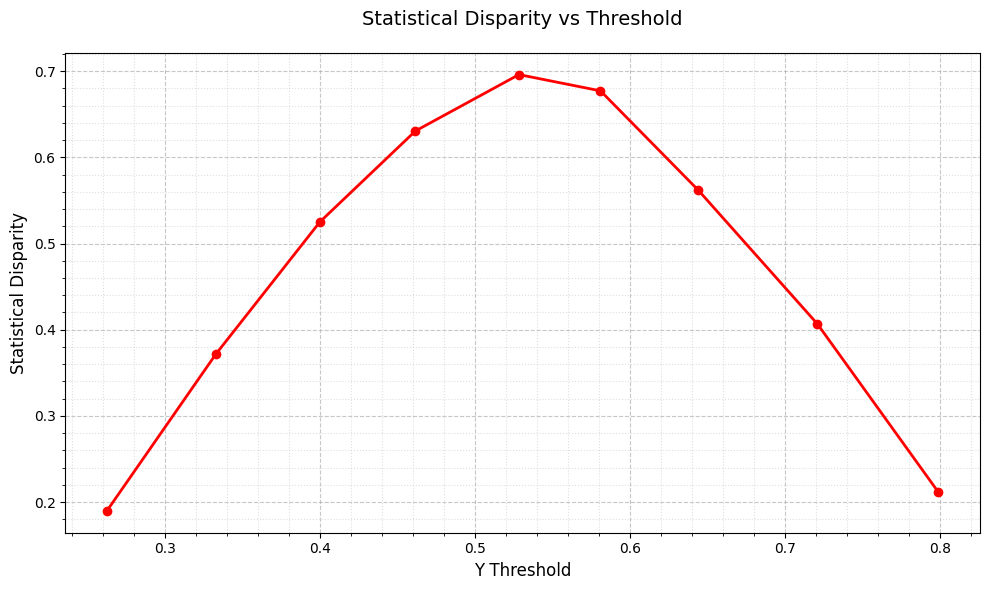


Summary Table of Results:
   threshold  statistical_disparity  P(A=1,Y=1)  P(A=0,Y=1)  P(Y=1|A=1)  \
0      0.263                  0.190       0.473       0.427       1.000   
1      0.333                  0.371       0.471       0.329       0.996   
2      0.400                  0.525       0.462       0.238       0.977   
3      0.462                  0.631       0.441       0.159       0.932   
4      0.528                  0.696       0.410       0.090       0.867   
5      0.581                  0.677       0.358       0.042       0.757   
6      0.644                  0.562       0.282       0.018       0.596   
7      0.721                  0.407       0.196       0.004       0.414   
8      0.799                  0.211       0.100       0.000       0.211   

   P(Y=1|A=0)  
0       0.810  
1       0.624  
2       0.452  
3       0.302  
4       0.171  
5       0.080  
6       0.034  
7       0.008  
8       0.000  


,threshold,statistical_disparity,"P(A=1,Y=1)","P(A=0,Y=1)",P(Y=1|A=1),P(Y=1|A=0)
0,0.262560,0.189753,0.473,0.427,1.000000,0.810247
1,0.332800,0.371483,0.471,0.329,0.995772,0.624288
2,0.400023,0.525131,0.462,0.238,0.976744,0.451613
3,0.461663,0.630639,0.441,0.159,0.932347,0.301708
4,0.528419,0.696030,0.410,0.090,0.866808,0.170778
5,0.581020,0.677175,0.358,0.042,0.756871,0.079696
6,0.644047,0.562039,0.282,0.018,0.596195,0.034156
7,0.720929,0.406786,0.196,0.004,0.414376,0.007590
8,0.799050,0.211416,0.100,0.000,0.211416,0.000000


In [67]:
analysis_results = plot_threshold_analysis(df, Y_thresh)
analysis_results

# Adult Data

## Static parameters

In [68]:
nb_seeds = 10
# Target attribute
target = 'income' 
# Protected attribute 
protected_att = 'gender'

# Folder where datasets are saved as csv files
datasets_path = os.path.join(os.getcwd(), 'Datasets/Adult/')
# Folder where plots are saved as pdf files
results_path = os.path.join(os.getcwd(), 'Plots/Adult/')

dataset_filename = 'adult_non_bin_outcome.csv'

percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
Y_thresholds = [f"th_{int(p*100)}%" for p in percentiles]

# Reading preprocessed dataset
df = pd.read_csv(os.path.join(datasets_path, dataset_filename))

# variable names
variable_names = df.columns.tolist()
variable_names

['hoursperweek',
 'age',
 'education',
 'maritalstatus',
 'race',
 'gender',
 'nativecountry',
 'income']

## Running experiments for the baseline causal model 

In [69]:
# results of PC estimation before binarization (baseline)
result_baseline = adj_matrices_generation_baseline(df)
causal_matrix = np.mean(result_baseline, axis=0)

# generate and save causal graph
generate_and_save_causal_graph(causal_matrix, variable_names, "causal_graph_Adult_baseline", "causal_graphs/Adult")


Causal graph saved as 'causal_graphs/Adult/causal_graph_Adult_baseline.gv.png'.


## Running experiments for the causal model after binarizing the outcome

In [70]:
# generating the adj matrices for all thresholds
Y_thresh = [df[target].quantile(p) for p in percentiles]
th_adj_matrix = adj_matrices_generation(df,Y_thresh,nb_seeds)

Threshold:  4650.0
++++++++++++++++++++++++++++++++++++++++++++
1    44577
0     4954
Name: income, dtype: int64
sd = 1.3437330439500814 

before -- [array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1,

In [71]:
# generate and save causal graphs for each threshold
for i, causal_matrix in enumerate(th_adj_matrix):
    threshold = Y_thresholds[i]
    filename = f"causal_graph_synthetic_{threshold}"
    generate_and_save_causal_graph(causal_matrix, variable_names, filename, "causal_graphs/Adult")

Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_10%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_20%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_30%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_40%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_50%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_60%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_70%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_80%.gv.png'.
Causal graph saved as 'causal_graphs/Adult/causal_graph_synthetic_th_90%.gv.png'.


## Check Statistical Disparity

In [72]:
# Baseline Disparity Ratio
# SD = E[Y|A=1] / E[Y|A=0]

E_Y_given_A1 = df[df[protected_att] == 1][target].mean()  # E[Y|A=1]
E_Y_given_A0 = df[df[protected_att] == 0][target].mean()  # E[Y|A=0]
SD = E_Y_given_A1 / E_Y_given_A0  # SD = E[Y|A=1] / E[Y|A=0]

print("\n=== Baseline Disparity Ratio ===")
print(f"E[Y|A=1]: {E_Y_given_A1:.3f}")
print(f"E[Y|A=0]: {E_Y_given_A0:.3f}")
print(f"Disparity Ratio: {SD:.3f}")


=== Baseline Disparity Ratio ===
E[Y|A=1]: 38679.592
E[Y|A=0]: 23024.960
Disparity Ratio: 1.680



=== Analysis for Threshold 4650.00 ===

1. Statistical Disparity:
   0.088

2. Joint Probabilities:
   P(A=1,Y=1): 0.622
   P(A=0,Y=1): 0.278

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.929
   P(Y=1|A=0): 0.841

=== Analysis for Threshold 9920.00 ===

1. Statistical Disparity:
   0.170

2. Joint Probabilities:
   P(A=1,Y=1): 0.573
   P(A=0,Y=1): 0.227

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.856
   P(Y=1|A=0): 0.686

=== Analysis for Threshold 15000.00 ===

1. Statistical Disparity:
   0.224

2. Joint Probabilities:
   P(A=1,Y=1): 0.515
   P(A=0,Y=1): 0.180

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.768
   P(Y=1|A=0): 0.545

=== Analysis for Threshold 20008.00 ===

1. Statistical Disparity:
   0.257

2. Joint Probabilities:
   P(A=1,Y=1): 0.459
   P(A=0,Y=1): 0.141

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.685
   P(Y=1|A=0): 0.428

=== Analysis for Threshold 26013.00 ===

1. Statistical Disparity:
   0.280

2. Joint Probabilities:
   P

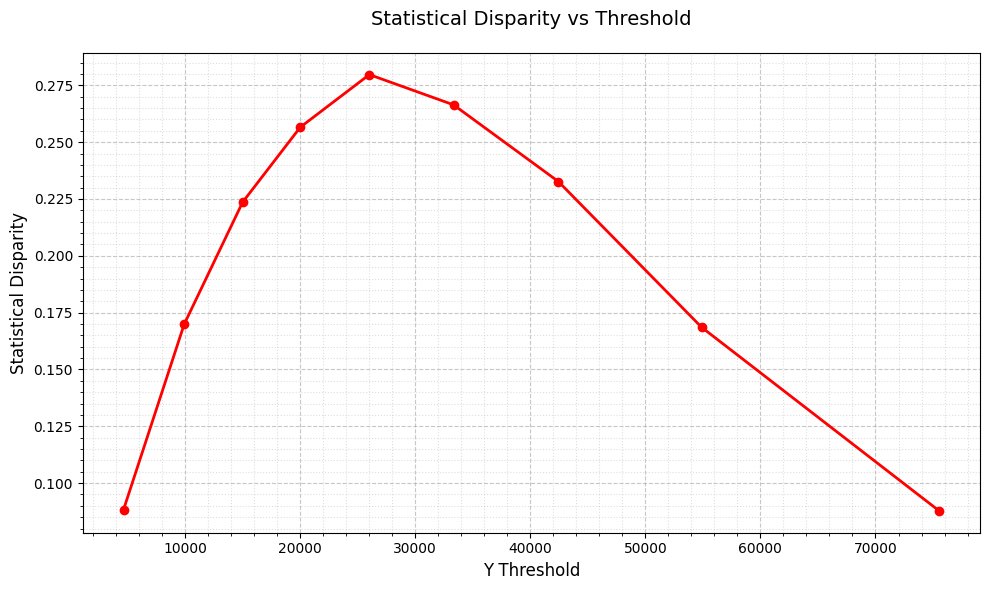


Summary Table of Results:
   threshold  statistical_disparity  P(A=1,Y=1)  P(A=0,Y=1)  P(Y=1|A=1)  \
0     4650.0                  0.088       0.622       0.278       0.929   
1     9920.0                  0.170       0.573       0.227       0.856   
2    15000.0                  0.224       0.515       0.180       0.768   
3    20008.0                  0.257       0.459       0.141       0.685   
4    26013.0                  0.280       0.397       0.103       0.592   
5    33325.0                  0.266       0.327       0.073       0.488   
6    42438.0                  0.233       0.252       0.048       0.377   
7    54894.0                  0.169       0.171       0.029       0.256   
8    75538.0                  0.088       0.086       0.014       0.129   

   P(Y=1|A=0)  
0       0.841  
1       0.686  
2       0.545  
3       0.428  
4       0.313  
5       0.221  
6       0.144  
7       0.087  
8       0.041  


,threshold,statistical_disparity,"P(A=1,Y=1)","P(A=0,Y=1)",P(Y=1|A=1),P(Y=1|A=0)
0,4650.0,0.088359,0.622317,0.277664,0.929161,0.840802
1,9920.0,0.169903,0.573378,0.226606,0.856092,0.686189
2,15000.0,0.223592,0.514546,0.179867,0.768252,0.544660
3,20008.0,0.256559,0.458541,0.141366,0.684633,0.428074
4,26013.0,0.279712,0.396741,0.103248,0.592361,0.312649
5,33325.0,0.266419,0.326704,0.073106,0.487792,0.221373
6,42438.0,0.232673,0.252387,0.047607,0.376831,0.144158
7,54894.0,0.168533,0.171226,0.028770,0.255652,0.087119
8,75538.0,0.087781,0.086390,0.013608,0.128987,0.041206


In [73]:
analysis_results = plot_threshold_analysis(df, Y_thresh)
analysis_results

# Fragrances Data

## Static parameters

In [74]:
nb_seeds = 10

# Target attribute
target = 'price_per_ml'
# Protected attribute 
protected_att = 'gender'

# Folder where datasets are saved as csv files
datasets_path = os.path.join(os.getcwd(), 'Datasets/Fragrances/')
# Folder where plots are saved as pdf files
results_path = os.path.join(os.getcwd(), 'Plots/Fragrances/')

dataset_filename = 'data_pink_tax_preprocessed.csv'


percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
Y_thresholds = [f"th_{int(p*100)}%" for p in percentiles]

# Reading preprocessed dataset
df = pd.read_csv(os.path.join(datasets_path, dataset_filename))

# variable names
variable_names = df.columns.tolist()

## Running experiments for the baseline causal model 

In [75]:
# results of PC estimation before binarization (baseline)
result_baseline = adj_matrices_generation_baseline(df)
causal_matrix = np.mean(result_baseline, axis=0)

# generate and save causal graph
generate_and_save_causal_graph(causal_matrix, variable_names, "causal_graph_Adult_baseline", "causal_graphs/Fragrances")


Causal graph saved as 'causal_graphs/Fragrances/causal_graph_Adult_baseline.gv.png'.


## Running experiments for the causal model after binarizing the outcome

In [76]:
# generating the adj matrices for all thresholds
Y_thresh = [df[target].quantile(p) for p in percentiles]
th_adj_matrix = adj_matrices_generation(df,Y_thresh,nb_seeds)

Threshold:  1.17
++++++++++++++++++++++++++++++++++++++++++++
1    484
0     55
Name: price_per_ml, dtype: int64
sd = 1.7536231884057971 

before -- [array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0,

In [77]:
# generate and save causal graphs for each threshold
for i, causal_matrix in enumerate(th_adj_matrix):
    threshold = Y_thresholds[i]
    filename = f"causal_graph_synthetic_{threshold}"
    generate_and_save_causal_graph(causal_matrix, variable_names, filename, "causal_graphs/Fragrances")

Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_10%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_20%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_30%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_40%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_50%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_60%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_70%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_80%.gv.png'.
Causal graph saved as 'causal_graphs/Fragrances/causal_graph_synthetic_th_90%.gv.png'.


## Check Statistical Disparity

In [78]:
# Baseline Disparity Ratio
# SD = E[Y|A=1] / E[Y|A=0]

E_Y_given_A1 = df[df[protected_att] == 1][target].mean()  # E[Y|A=1]
E_Y_given_A0 = df[df[protected_att] == 0][target].mean()  # E[Y|A=0]
SD = E_Y_given_A1 / E_Y_given_A0  # SD = E[Y|A=1] / E[Y|A=0]

print("\n=== Baseline Disparity Ratio ===")
print(f"E[Y|A=1]: {E_Y_given_A1:.3f}")
print(f"E[Y|A=0]: {E_Y_given_A0:.3f}")
print(f"Disparity Ratio: {SD:.3f}")


=== Baseline Disparity Ratio ===
E[Y|A=1]: 4.760
E[Y|A=0]: 3.727
Disparity Ratio: 1.277



=== Analysis for Threshold 1.17 ===

1. Statistical Disparity:
   0.016

2. Joint Probabilities:
   P(A=1,Y=1): 0.464
   P(A=0,Y=1): 0.434

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.906
   P(Y=1|A=0): 0.890

=== Analysis for Threshold 2.14 ===

1. Statistical Disparity:
   0.039

2. Joint Probabilities:
   P(A=1,Y=1): 0.419
   P(A=0,Y=1): 0.380

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.819
   P(Y=1|A=0): 0.779

=== Analysis for Threshold 2.99 ===

1. Statistical Disparity:
   0.118

2. Joint Probabilities:
   P(A=1,Y=1): 0.388
   P(A=0,Y=1): 0.312

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.757
   P(Y=1|A=0): 0.639

=== Analysis for Threshold 3.63 ===

1. Statistical Disparity:
   0.198

2. Joint Probabilities:
   P(A=1,Y=1): 0.353
   P(A=0,Y=1): 0.239

3. Conditional Probabilities P(Y|A):
   P(Y=1|A=1): 0.688
   P(Y=1|A=0): 0.490

=== Analysis for Threshold 4.00 ===

1. Statistical Disparity:
   0.206

2. Joint Probabilities:
   P(A=1,Y=1): 0.306
 

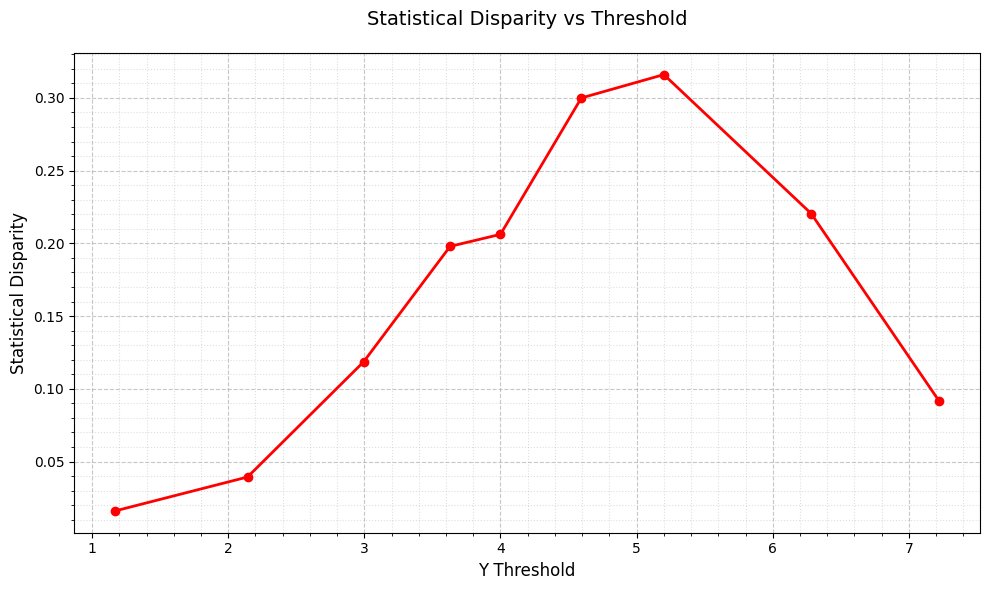


Summary Table of Results:
   threshold  statistical_disparity  P(A=1,Y=1)  P(A=0,Y=1)  P(Y=1|A=1)  \
0      1.170                  0.016       0.464       0.434       0.906   
1      2.142                  0.039       0.419       0.380       0.819   
2      2.994                  0.118       0.388       0.312       0.757   
3      3.630                  0.198       0.353       0.239       0.688   
4      4.000                  0.206       0.306       0.191       0.598   
5      4.594                  0.300       0.280       0.121       0.547   
6      5.200                  0.316       0.232       0.067       0.453   
7      6.282                  0.221       0.158       0.043       0.308   
8      7.220                  0.092       0.072       0.024       0.141   

   P(Y=1|A=0)  
0       0.890  
1       0.779  
2       0.639  
3       0.490  
4       0.392  
5       0.247  
6       0.137  
7       0.087  
8       0.049  


,threshold,statistical_disparity,"P(A=1,Y=1)","P(A=0,Y=1)",P(Y=1|A=1),P(Y=1|A=0)
0,1.170,0.016063,0.463822,0.434137,0.905797,0.889734
1,2.142,0.039373,0.419295,0.380334,0.818841,0.779468
2,2.994,0.118463,0.387755,0.311688,0.757246,0.638783
3,3.630,0.197912,0.352505,0.239332,0.688406,0.490494
4,4.000,0.206191,0.306122,0.191095,0.597826,0.391635
5,4.594,0.299953,0.280148,0.120594,0.547101,0.247148
6,5.200,0.316016,0.231911,0.066790,0.452899,0.136882
7,6.282,0.220519,0.157699,0.042672,0.307971,0.087452
8,7.220,0.091875,0.072356,0.024119,0.141304,0.049430


In [79]:
analysis_results = plot_threshold_analysis(df, Y_thresh)
analysis_results